# Implementation from scratch of an RBM
# Assignment 3 - Alessio Cascione

### Section 1 - RBM implementation

The following code shows an implementation of a Restricted Boltzmann Machine (RBM) with standard contrastive divergence approach (considering a Gibbs sampling for k = 1) for training, including L2 regularization parameters for the weights and introducing momentum, following the weight update rule suggested in [Shen, Li](https://www.sciencedirect.com/science/article/pii/S0925231219310811) (pg.42, equation 10):



> To accelerate the entire network convergence, our momentum method with a small amount of weight decay adopted the combination of the previous gradient value and the positive direction of the current gradient, as follows:


> $\theta_{(t)} = \theta_{(t-1)} + m^*\Delta \theta_{(t-1)} + \eta(\frac{\partial L(\theta) }{\partial \theta_i}) -\lambda_1\theta_{(t-1)}$

Where $λ_1$ is the weight decay term, $m^*$ the momentum term, $\eta$ the learning rate and $\theta$ the RBM parameters.

A further note regarding the contrastive divergence implementation must be specified. Following section 1.2 by [Goh, Thome and Cord](https://webia.lip6.fr/~cord/pdfs/publis/NIPS2010_Goh.pdf):


> The activation probabilities of $v_i$ and $h_j$ may be used in place of their binary states for parameter updates (see[[7]](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)). This process, known as Rao-Blackwellization [[1]](https://www.jstor.org/stable/2236107
), results in an estimator with lower variance[[18]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5454138).

Therefore we update the weights and the biases using activation probabilities instead of samples in order to obtain a lower variance estimate (treating biases' update rules with the same probabilistic approach, given the fact that biases can be thought as connections linked to "imaginary" hidden and visible units always set to 1)




In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error
import seaborn as sns
from tqdm import tqdm


from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

#express mnist in terms of values in [0,1] interval

X_train = X_train / 255
X_test = X_test / 255

#reshape mnist images into flat vectors

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

#performa a train_test split on the training set for naive model selection phase (using standard hold-out method)

X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, random_state = 42)

#define sigmoid function for RBM
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

#define auxiliary comparison function among two images (original, reconstructed)
def comparison(x,y,function):
  x = np.reshape(x,newshape=(28, 28))
  y = np.reshape(y,newshape=(28, 28))
  return function(x,y)

def selection(params_list, X_train_val, X_test_val):
  rank_models = {}

  for params in params_list:

    batch_size = params['batch_size']
    decay_W  = params['decay_W']
    decay_h = params['decay_h']
    decay_v = params['decay_v']
    epochs = params['epochs']
    lr = params['lr']
    momentum = params['momentum']

    rbm = RBM(visible_units=len(X_train_val[0]), hidden_units=100)

    rbm.fit(X_train = X_train_val, y_train = y_train_val,
            epochs=epochs, lr=lr, k=1, batch_size=batch_size, momentum = momentum,
            decay_W = decay_W, decay_v = decay_v, decay_h = decay_h)

    rank_models[rbm.evaluate_reconstructions(X_test_val)] = params

  return rank_models




param_grid = {'epochs': [1,5], 'lr': [0.1], 'batch_size' : [1,100,6000], 'momentum' : [0.0,0.5,0.9],
              'decay_W' : [0.0,0.0001], 'decay_v' : [0.0], 'decay_h' : [0.0] }
params_list = list(ParameterGrid(param_grid))


In [ ]:
class RBM ():

    def __init__(self, visible_units, hidden_units, v_bias=None, h_bias=None):

      #define the number of visible and hidden units, along with the random initial weights in [-1, 1) interval
      #set hidden and visible bias to a 0s array if v_bias/h_bias is None.

        self.v_units = visible_units
        self.h_units = hidden_units

        self.weights = np.random.uniform(-1, 1, size=(hidden_units, visible_units))
        self.v_bias = v_bias if v_bias is not None else np.zeros(visible_units)
        self.h_bias = h_bias if h_bias is not None else np.zeros(hidden_units)

    def get_visible_hidden(self, h_sample):
      #given an hidden sample, obtain the visible probabilities and a sample from these probabilities
        v_probabilities = sigmoid(np.matmul(h_sample, self.weights) + self.v_bias)
        v_sample = np.random.binomial(n=1, p=v_probabilities)
        return v_probabilities, v_sample

    def get_hidden_visible(self, v_sample):
       #given a visible sample, obtain the hidden probabilities and a sample from these probabilities
        h_probabilities = sigmoid(np.matmul(self.weights, v_sample) + self.h_bias)
        h_sample = np.random.binomial(n=1, p=h_probabilities)
        return h_probabilities, h_sample

    def gibbs_sampling(self, h_sample, iter):
      #perform Gibbs sampling for a certain number of iterations
        v_probabilities, h_probabilities, v_sample = None, None, None
        for i in range(iter):
            v_probabilities, v_sample = self.get_visible_hidden(h_sample)
            h_probabilities, h_sample = self.get_hidden_visible(v_sample)
        return v_probabilities, h_probabilities, v_sample, h_sample

    def contrastive_divergence(self, v_probabilities, k):
    #perform contrastive divergence using "k" iterations for the gibbs sampling phase


    #given a vector of probability v_probabilities, binarize the vector and get
    #hidden probabilities and samples for the positive phase

      data = np.random.binomial(n=1, p=v_probabilities)
      poshidP, poshidS = self.get_hidden_visible(data)

    #compute the wake - positive term as an outer product of poshidP and v_probabilities
      wake = np.outer(poshidP, v_probabilities)

    #perform Gibbs sampling and obtain the dream - negative term as an outer product of neghidP and reconDataP
      reconDataP, neghidP, reconData, neghidS = self.gibbs_sampling(poshidS, k)
      dream = np.outer(neghidP, reconDataP)


      deltaW = wake - dream
      deltaBh = poshidP - neghidP
      deltaBv = v_probabilities - reconDataP


      return deltaW, deltaBv, deltaBh


    def encode(self, instance):
    #simple function to obtain an encoding of an instance, in the form of the hidden probabilities and the respective sample
      instance_sample = np.random.binomial(n=1, p=instance, size = len(instance))
      poshidP, poshidS = self.get_hidden_visible(instance_sample)
      return poshidP, poshidS

    def reconstruct(self, instance, show = False):
    #function used to reconstruct the instance and show a comparison if needed
      poshidP, poshidS = self.encode(instance)
      reconDataP, reconData = self.get_visible_hidden(poshidS)

      if show:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(np.reshape(instance, newshape=(28, 28)))
        ax[0].set_title('Original')
        ax[1].imshow(np.reshape(reconDataP, newshape=(28, 28)))
        ax[1].set_title('Reconstructed')
        fig.show()

      return reconDataP, reconData

    def evaluate_reconstructions(self, X_test):
      #evaluate the reconstructions of RBM given a test set
      #comparing each reconstruction with the original using MSE

      errors = 0
      for instance in X_test:
        reconDataP, reconData = self.reconstruct(instance)

        errors += (mean_squared_error(instance, reconDataP))

      return errors / len(X_test)

    def fit(self, X_train, y_train, epochs=1, lr=0.1, k=1, batch_size=1, momentum = 0.1, decay_W = 0.001, decay_v = 0.0, decay_h = 0.0):

    #training function for the RBM, considering epochs, batch_size, learning rate, momentum and regularization parameters.

        self.train_imgs, self.train_labels = X_train, y_train
        n_instances = len(self.train_labels)
        indexes = list(range(n_instances))

        #initialize old_delta_W/Bv/Bh for the momentum
        old_delta_W = np.zeros(shape=self.weights.shape)
        old_delta_Bv = np.zeros(shape=(len(self.v_bias),))
        old_delta_Bh = np.zeros(shape=(len(self.h_bias),))


        for epoch in range(epochs):
            np.random.shuffle(indexes)

            self.train_imgs = self.train_imgs[indexes]
            self.train_labels = self.train_labels[indexes]


            for batch_idx in tqdm(range(math.ceil(len(self.train_labels)/batch_size))):

                start = batch_idx * batch_size
                end = start + batch_size
                batch_instances = self.train_imgs[start:end]

                deltaW = np.zeros(shape=self.weights.shape)
                deltaBv = np.zeros(shape=(len(self.v_bias),))
                deltaBh = np.zeros(shape=(len(self.h_bias),))



                for instance in batch_instances:
                  #perform contrastive divergence on each instance of the mini-batch

                    dW, dBv, dBh = self.contrastive_divergence(v_probabilities=instance, k=k)
                    deltaW = np.add(deltaW, dW)
                    deltaBv = np.add(deltaBv, dBv)
                    deltaBh = np.add(deltaBh, dBh)

              #update the weights, visible bias and hidden bias
                self.weights += (lr / batch_size) * deltaW + (momentum * old_delta_W) - (decay_W * self.weights)
                self.v_bias += (lr / batch_size) * deltaBv + (momentum * old_delta_Bv) - (decay_v * self.v_bias)
                self.h_bias += (lr / batch_size) * deltaBh + (momentum * old_delta_Bh) - (decay_h* self.h_bias)


              #update the momentum delta
                old_delta_W = (lr / batch_size) * deltaW
                old_delta_bv =  (lr / batch_size) * deltaBv
                old_delta_bh = (lr / batch_size) * deltaBh




### Section 2 - RBM training phase and results evaluation


For the model selection, we perform a simple hold-out methodology over the MNIST training set, using 25% of the original training as validation set and the remaing part as training set during the model selection.

As a selection strategy, we first fit all the models and then reconstruct the validation set images using the trained RBMs: we then choose the RBM having the lowest average reconstruction error over the validation set, using MSE as a metric to compare the similarity between an original image belonging to the validation set and its reconstructed counterpart.

Having chosen the best RBM, we fit it on the original 60000 images long MNIST training set and obtain the reconstructed version of the 10000 images long test set.

In [ ]:
#performing the model selection: the output has been cleaned for notebook readability
rank_models = selection(params_list, X_train_val, X_test_val)

In [ ]:
#printing out the best three models with respect to the mean MSE between validation and reconstructions
for i in sorted(rank_models.keys())[0:3]:
  print(i, rank_models[i])

0.023641674535299993 {'batch_size': 1, 'decay_W': 0.0001, 'decay_h': 0.0, 'decay_v': 0.0, 'epochs': 5, 'lr': 0.1, 'momentum': 0.0}
0.025050885046305815 {'batch_size': 1, 'decay_W': 0.0, 'decay_h': 0.0, 'decay_v': 0.0, 'epochs': 5, 'lr': 0.1, 'momentum': 0.0}
0.02533287850158067 {'batch_size': 1, 'decay_W': 0.0001, 'decay_h': 0.0, 'decay_v': 0.0, 'epochs': 1, 'lr': 0.1, 'momentum': 0.0}


In [ ]:
#fitting the best model over the whole training set
rbm = RBM(visible_units=len(X_train[0]), hidden_units=100)
rbm.fit(X_train = X_train, y_train = y_train, epochs=5, lr=0.1, k=1, batch_size=1, momentum = 0.0, decay_W = 0.0001, decay_v = 0.0, decay_h = 0.0)

100%|██████████| 60000/60000 [01:47<00:00, 556.23it/s]


In order to compare the reconstructed images with the original test ones, we use the structural similarity index measure (SSIM), based on the comparison of luminance, contrast and structure similarity instead of the simple MSE used only for validation purposes:

> When comparing images, the mean squared error (MSE)–while simple to implement–is not highly indicative of perceived similarity. Structural similarity aims to address this shortcoming by taking texture into account - as suggested in the [skimage-library and relative papers](https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html#id2).

In our case, MSE was used as a naive criterion to find the best model in the simple model selection discussed above: we prefer using a more robust and "interpretable" measure, given the fact that SSIM ranges between 0 (minimal similarity) and 1 (maximal similarity),  in the context of direct comparison with the whole test set.



In [ ]:
#obtain all the test set reconstructions
X_test_reconstruction = [rbm.reconstruct(image)[0] for image in X_test]

In [ ]:
#a pandas dataframe is defined in order to better manage the reconstructions
d = {'X_test' : list(X_test), 'X_test_reconstruction': (X_test_reconstruction), 'y_test': y_test}
df = pd.DataFrame(data=d)

SSIM = [comparison(row['X_test_reconstruction'], row['X_test'], structural_similarity) for index, row in df.iterrows()]
df['SSIM'] = SSIM


The table belows illustrates the average SSIM between reconstructed and original images for each digit class in the test set. Furthermore, a single particular example for each digit is reported, too.

Results are, on average, satisfactory for the 0, 1, 7 and 9 digits, having a mean SSIM above or very close to 0.8, while improvements might be desirable for the other labels.

In [ ]:
summary_table = df.groupby('y_test', as_index=False)['SSIM'].mean()
summary_table

,y_test,SSIM
0,0,0.799698
1,1,0.870096
2,2,0.722343
3,3,0.750964
4,4,0.744279
5,5,0.739418
6,6,0.762501
7,7,0.785948
8,8,0.738440
9,9,0.798043


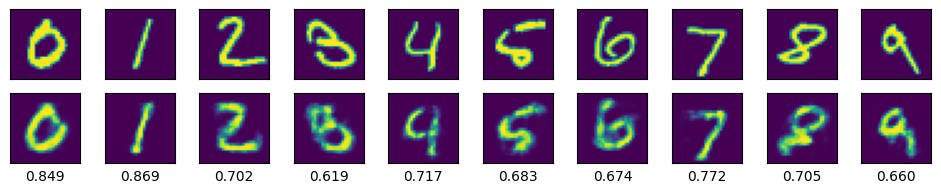

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(12, 2))
for i in range(10):
  for index, row in df.iterrows():

    if row['y_test'] == i:
      original = row['X_test']
      recon = row['X_test_reconstruction']
      ssim = row['SSIM']


      ax[0, i].imshow(np.reshape(original, newshape=(28, 28)))
      ax[0, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
      ax[1, i].imshow(np.reshape(recon, newshape=(28, 28)))
      ax[1, i].set_xlabel("{:.3f}".format(ssim))
      ax[1, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

      break

### Section 3 - Brief comments and conclusions



We have discussed a simple implementation of an RBM with contrastive divergence approach for the training phase, obtaining a satisfactory but improvable results.

In order to check if better results are possible using an RBM architectures, different training methodologies could be adopted in principle, to see if they lead to changes in performances (for instance, considering average contrastive divergence as discussed in [Ma, Wang](https://www.mdpi.com/1099-4300/18/1/35)).

A more principled model selection could be adopted, too - taking into account $k$-fold cross validation and more distinct configurations.

At last, Deep Restricted Boltzmann Networks can be seen as a composition of RBM: it could be possible to see if extending the implementation with these could lead to better final performances.